In [2]:
input_model = 'distilbert'

In [3]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [4]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 799.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.0 MB/s eta 0:00:00


In [6]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [7]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512

# Max embeddings in BERT
BERT_MAX_EMBEDDINGS = 1024

# fraction of data to use for training
FRACTION = 1.0

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [8]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.25.2
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.0.3
sklearn version: 1.2.2


In [9]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [10]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = f'{BASE_PATH}/Reddit/both_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/both_test.csv'
rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)


# Split data into test and train
train_size = int(0.8 * len(rdt_train))
X_train = rdt_train[0:train_size].post
X_val = rdt_train[train_size:].post
X_test = rdt_test.post
y_train = rdt_train[0:train_size].class_id
y_val = rdt_train[train_size:].class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [11]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['none' 'anxiety' 'ptsd' 'bipolar' 'adhd' 'depression']


array([5, 1, 4, 2, 0, 3])

In [12]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (10981,)
Validation set labels shape: (2746,)
Test set labels shape: (1488,)
Training set examples shape: (10981,)
Validation set examples shape: (2746,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


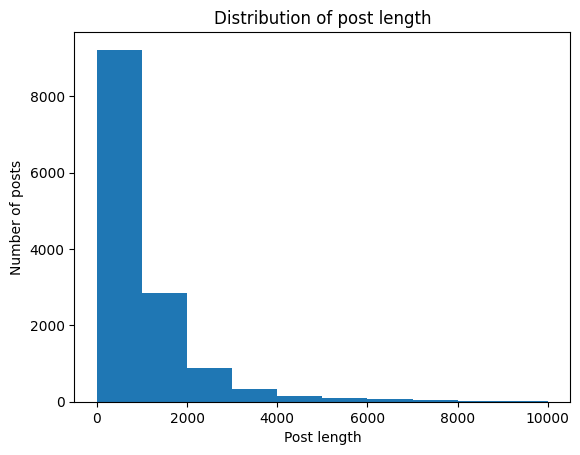

In [13]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [14]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 1980/10981 (0.18031144704489574)
Labels 1 in training set: 1928/10981 (0.1755759949002823)
Labels 2 in training set: 1913/10981 (0.17420999908933613)
Labels 3 in training set: 1980/10981 (0.18031144704489574)
Labels 4 in training set: 1601/10981 (0.14579728622165558)
Labels 0 in validation set: 485/2746 (0.1766205389657684)
Labels 1 in validation set: 494/2746 (0.1798980335032775)
Labels 2 in validation set: 494/2746 (0.1798980335032775)
Labels 3 in validation set: 470/2746 (0.17115804806991988)
Labels 4 in validation set: 400/2746 (0.14566642388929352)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [15]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{5: 'none', 1: 'anxiety', 4: 'ptsd', 2: 'bipolar', 0: 'adhd', 3: 'depression'}
{'none': 5, 'anxiety': 1, 'ptsd': 4, 'bipolar': 2, 'adhd': 0, 'depression': 3}


In [16]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [17]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [18]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [19]:


def distilbert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train distilbert model
    """

    LEARNING_RATE = 5e-5
    BATCH_SIZE = 16
    NUM_EPOCHS = 3

    NUM_LABELS = np.max(tlabels) + 1
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels= NUM_LABELS)

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    train_samples = tsamples.tolist()
    vsamples = val[0:int(fraction*len(val))]
    val_samples = vsamples.tolist()

    # Convert labels to numpy arrays
    train_labels = np.array(tlabels)
    train_sample_labels = train_labels[0:int(fraction*len(tlabels))]

    val_labels = np.array(vlabels)
    val_sample_labels = val_labels[0:int(fraction*len(vlabels))]

    # Tokenize training, validation and test data
    distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, train_samples)),  # Convert BatchEncoding instance to dictionary
        train_sample_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, val_samples)),  # Convert BatchEncoding instance to dictionary
        val_sample_labels)).batch(BATCH_SIZE).prefetch(1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics='accuracy')

    model.summary()

    model_history = model.fit(
        train_dataset,
        y=None,
        validation_data=val_dataset,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS)

    return model, model_history



In [21]:
fraction = 1

In [22]:
model, model_history = distilbert_main(train_examples, val_examples, train_labels, val_labels, fraction)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
687/687 [===========================

In [23]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_examples_list = test_examples.tolist()
test_tokens = tokenize_data(distilbert_tokenizer, test_examples_list)
y_prediction = model.predict((dict(test_tokens),)) # Pass a tuple to predict
# Extract the NumPy array from the dictionary
y_prediction = y_prediction[0] # Extract the NumPy array

47/47 [==============================] - 11s 209ms/step


In [24]:
# Convert predicted probabilities to class labels
y_pred_label = np.argmax(y_prediction, axis=1)

	 Printing confusion matrix


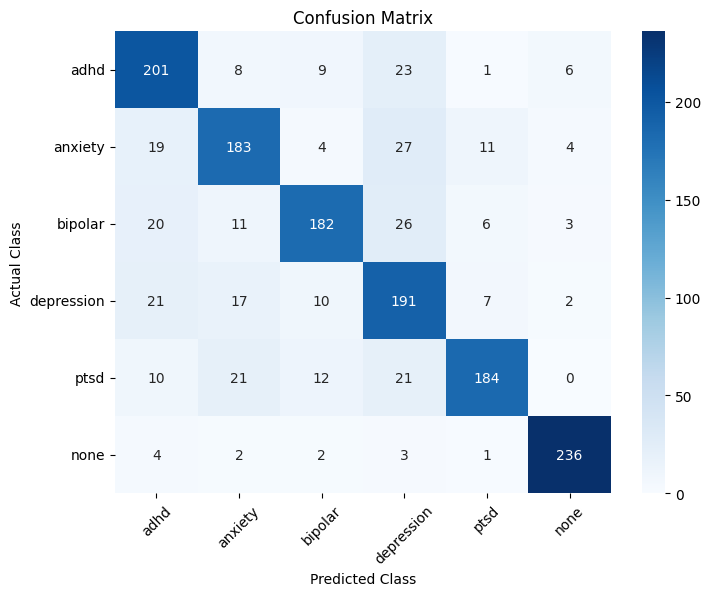

Accuracy: 0.790994623655914
              precision    recall  f1-score   support

        adhd       0.73      0.81      0.77       248
     anxiety       0.76      0.74      0.75       248
     bipolar       0.83      0.73      0.78       248
  depression       0.66      0.77      0.71       248
        ptsd       0.88      0.74      0.80       248
        none       0.94      0.95      0.95       248

    accuracy                           0.79      1488
   macro avg       0.80      0.79      0.79      1488
weighted avg       0.80      0.79      0.79      1488



In [25]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [ ]:
fraction

1

In [26]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/mismatches_distilbert.csv', index=False)


	 Saving all mismatches
